In [47]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

from scipy.optimize import minimize
from scipy import signal
from astropy.convolution import Gaussian2DKernel

from scipy.optimize import minimize
import lightkurve as lk
import tessreduce as tr
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(299.618917,62.137731, unit=(u.deg, u.deg), frame='icrs')

tess = lk.search_tesscut(c)


In [9]:
def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

In [11]:
tpf = tess[0].download(cutout_size=50)
red = tr.Quick_reduce(s11,calibrate=False)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [27]:
zp = 20.44
tab = tr.Unified_catalog(tpf,magnitude_limit=19,offset=-1)
col = tab.col.values 
row = tab.row.values 
pos = np.array([col,row]).T

median = np.nanmedian(red['flux'],axis=0)
tcounts = 10**(-2/5*(tab.tmag.values - zp))

In [44]:
max(tcounts)

51236.63950714807

In [28]:
max(col)

48.97501133538983

In [43]:
median

array([[ 3.42536189e+01,  3.41632471e+01,  6.47594588e+00, ...,
         1.75605871e+01,  1.11732718e+02,  3.22752162e+02],
       [ 2.90561783e+01,  3.84140366e+01,  6.97115525e+00, ...,
         3.06560366e+01,  1.37619718e+02,  2.17460466e+02],
       [ 3.23464527e+01,  2.66010284e+01,  8.41458964e-02, ...,
         8.47006902e+01,  6.25693547e+01,  6.60287645e+01],
       ...,
       [-5.22367798e-03,  9.77271021e-03,  8.31194833e-03, ...,
         4.28608685e+00,  7.36468765e+01,  3.71857837e+02],
       [ 1.30819969e-03,  1.16437921e-03, -9.90832551e-03, ...,
         8.17183044e-01,  8.18724844e+01,  4.62011923e+02],
       [ 1.92778241e-05,  1.75325078e-03, -7.15478630e-03, ...,
         2.48518923e+00,  3.20401113e+01,  1.67547596e+02]])

In [41]:
scene = np.zeros_like(median)
for i in range(len(col)):
    r = int(np.round(row[i],0))
    c = int(np.round(col[i],0))
    scene[r,c] += tcounts[i]

<IPython.core.display.Javascript object>


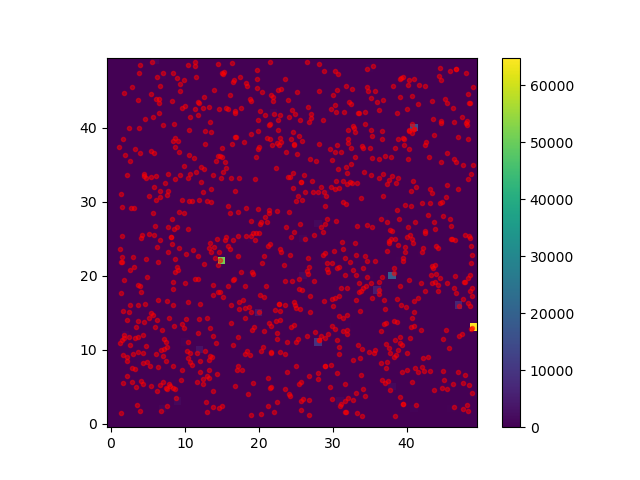

In [45]:
plt.figure()
plt.imshow(scene,origin='lower')
plt.plot(pos[:,0],pos[:,1],'r.',alpha=0.5)
plt.colorbar()

In [75]:
def Delta_kernal(Scene,Image,Size=13):
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,TESS),
                   bounds=bds,options={'disp': True})
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def optimize_delta(Coeff, Basis, Scene, Image):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    template = template #/ np.nanmax(template)
    
    return np.nansum(abs(Image - template))
    
def optimize_delta(Coeff, Basis, Scene, TESS):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    #template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]
    template[template == 0] = np.nan
    TESS[TESS == 0] = np.nan
    template = -2.5*np.log10(template)+20.44 #/ np.nanmax(template)
    
    tess = -2.5*np.log10(TESS.copy())+20.44 #/ np.nanmax(TESS)
    res = np.nansum(abs(tess - template))
    return res
    
    

In [103]:
Basis, coeff_0 = Delta_basis(7)
bds = []
for i in range(len(coeff_0)):
    bds += [(0,1)]

In [115]:
res = minimize(optimize_delta, coeff_0, args=(Basis,red['flux'][100],median),options={'disp': True})
res

         Current function value: 2127.195044
         Iterations: 21
         Function evaluations: 4056
         Gradient evaluations: 81


      fun: 2127.1950442359107
 hess_inv: array([[ 0.72043407, -0.21493697,  0.04337244, ..., -0.01439105,
         0.13563379, -0.0480244 ],
       [-0.21493697,  0.69891949, -0.02934509, ..., -0.02736991,
         0.01760101, -0.02570763],
       [ 0.04337244, -0.02934509,  0.290652  , ..., -0.07697069,
         0.13171658, -0.06023204],
       ...,
       [-0.01439105, -0.02736991, -0.07697069, ...,  0.34180017,
        -0.41200076,  0.10682789],
       [ 0.13563379,  0.01760101,  0.13171658, ..., -0.41200076,
         0.87823793, -0.25459382],
       [-0.0480244 , -0.02570763, -0.06023204, ...,  0.10682789,
        -0.25459382,  0.52166433]])
      jac: array([-10.81167603, -10.5088501 ,  -2.96481323,  16.45828247,
        47.33413696,  42.64764404,  46.46304321, -13.4241333 ,
         5.12969971,   9.04724121,  22.53683472,  68.93612671,
        51.94085693,  50.63577271, -22.09109497,  16.82727051,
        21.40325928,  14.23358154,   9.19506836,   3.13467407,
        26.05770874,

In [117]:
Kernal = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)

<IPython.core.display.Javascript object>


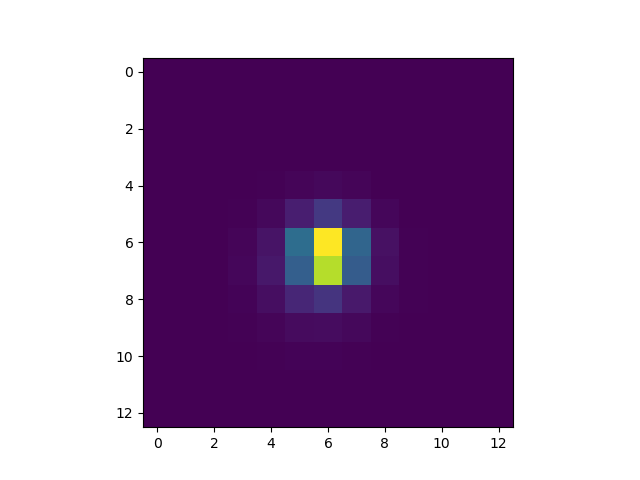

In [118]:
plt.figure()
plt.imshow(kernal)

In [119]:
template = signal.fftconvolve(median, kernal, mode='same')
template = template #/ np.nanmax(template)

<IPython.core.display.Javascript object>


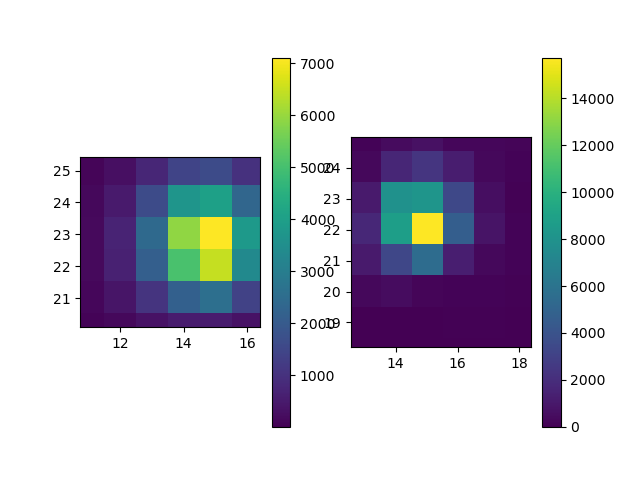

In [121]:
plt.figure()
plt.subplot(121)
plt.imshow(template,origin='')
plt.colorbar()
plt.subplot(122)
plt.imshow(red['flux'][100],origin='')
plt.colorbar()

<IPython.core.display.Javascript object>


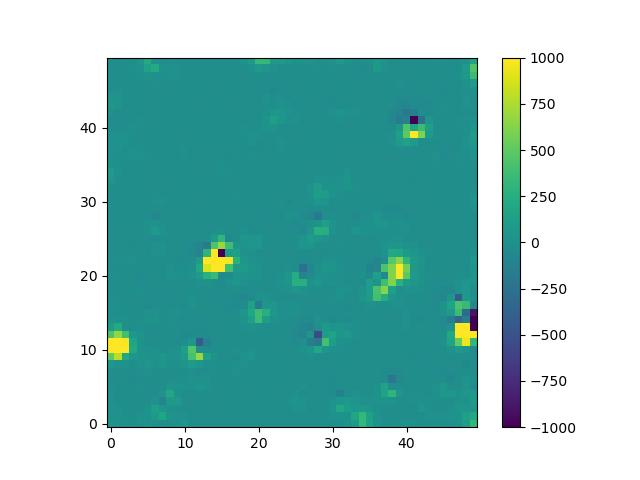

In [89]:
plt.figure()
plt.imshow((median-template),origin='',vmin=-1000,vmax=1000)
plt.colorbar()

<IPython.core.display.Javascript object>


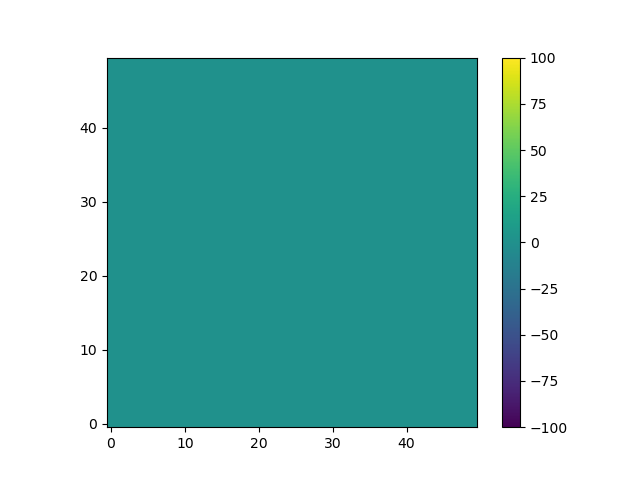

In [94]:
plt.figure()
plt.imshow((median)/median,origin='',vmax=100,vmin=-100)
plt.colorbar()

In [135]:
from astropy.convolution import Gaussian2DKernel

a = Gaussian2DKernel(10,10,.1,x_size=100,y_size=100)

<IPython.core.display.Javascript object>


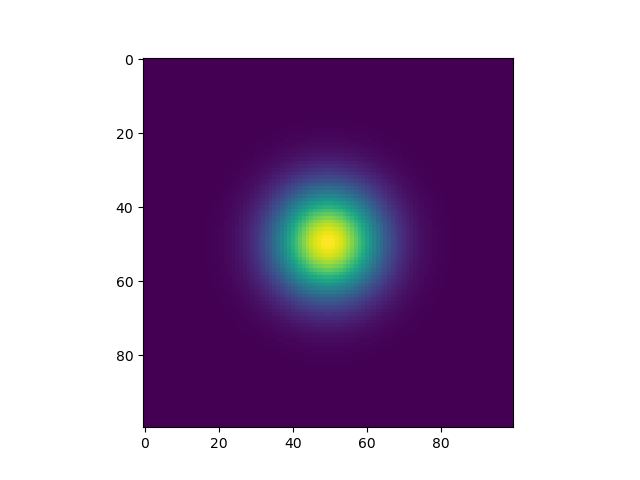

In [136]:
plt.figure()
plt.imshow(a)

In [137]:
np.nansum(a)

0.9999988657042357

In [138]:
tab

,objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gmag,e_gmag,gKmag,e_gKmag,rmag,...,yKmag,e_yKmag,tmag,gaiaid,gaiamag,gaiadist,gaiadist_u,gaiadist_l,row,col
1268,182402996766947522,299.676649,62.005620,0.0033,0.0050,18.2910,0.0050,18.3793,0.0075,17.8918,...,17.7643,0.0337,17.760811,2238066741655760384,17.9272,717.712967,755.018671,683.862981,48.878642,26.588261
1284,182412997357574152,299.735715,62.011136,0.0050,0.0030,18.2628,0.0046,18.3553,0.0056,17.7025,...,17.4714,0.0145,17.478136,2238066814674475008,17.7585,3921.696612,5290.305079,2993.385449,48.883790,21.456710
1289,182432997069585537,299.706963,62.028966,0.0045,0.0081,19.2547,0.0067,19.3680,0.0271,18.5034,...,17.9852,0.0359,18.146436,2238066879094743936,18.5516,1571.894507,3009.566586,760.252042,45.269451,23.045707
1294,182422997047016297,299.704734,62.021291,0.0119,0.0041,18.8519,0.0050,18.9232,0.0153,17.9238,...,17.2368,0.0180,17.461264,2238066879094735488,17.9685,1264.003203,1725.296235,989.295347,46.584019,23.570097
1296,182432997116597163,299.711680,62.030342,0.0036,0.0049,16.9212,0.0060,16.9582,0.0037,16.5227,...,16.3752,0.0122,16.383678,2238066883393950976,16.5450,902.767917,934.653799,872.949928,45.105135,22.594764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,182662992870168488,299.287053,62.223072,0.0135,0.0252,14.1806,0.0035,14.2367,0.0010,13.4954,...,13.0698,0.0024,13.329967,2238131410982660096,13.5418,NaN,NaN,NaN,4.085852,48.917799
10354,182682992956504332,299.295633,62.236283,0.0034,0.0039,18.5572,0.0066,18.6421,0.0094,18.1854,...,18.0312,0.0314,18.047936,2238132888451409664,18.2159,NaN,NaN,NaN,1.907960,47.614029
10360,182682993101654169,299.310415,62.236143,0.0108,0.0198,14.6304,0.0022,14.6810,0.0041,14.2127,...,14.0309,0.0046,14.077580,2238132888451410176,14.2275,NaN,NaN,NaN,2.182650,46.408374
10370,182672992904069509,299.290322,62.232236,0.0038,0.0053,21.5592,0.0595,21.6414,0.1260,20.3565,...,18.1688,0.0221,18.755555,2238132888451473152,19.7240,NaN,NaN,NaN,2.529593,48.233290


In [223]:
def Gaussian_kernal(sigx,sigy,thet):
    kernal = Gaussian2DKernel(sigx,sigy,thet,x_size=200,y_size=200)
    return kernal

def Make_scene(table,zp,tpf,scale=100):
    offset = 10
    col = ((table['col'].values + 10)*scale).astype(int)
    row = ((table['row'].values + 10)*scale).astype(int)
    
    tcounts = 10**(-2/5*(table['tmag'].values-zp))
    
    template = np.zeros(((tpf.shape[1]+20)*scale,(tpf.shape[2]+20)*scale))
    template[row,col] = tcounts
    template = template[offset*scale:int((offset + tpf.shape[1])*scale),offset*scale:int((offset +tpf.shape[2])*scale)]
    return template

In [211]:
bleh = Make_scene(tab,20.44,tpf)
kernal = Gaussian_kernal(50,50,0)

(7000, 7000)
(5000, 5000)


In [212]:
median.shape

(50, 50)

In [213]:
template = signal.fftconvolve(bleh, kernal, mode='same')

<IPython.core.display.Javascript object>


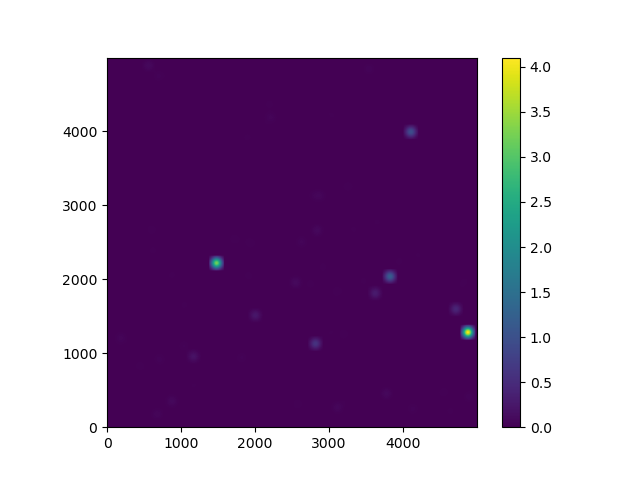

In [214]:
plt.figure()
plt.imshow(template,origin='')
plt.colorbar()

In [215]:
eh = sd.Downsample(template,100,pix_response=False)

<IPython.core.display.Javascript object>


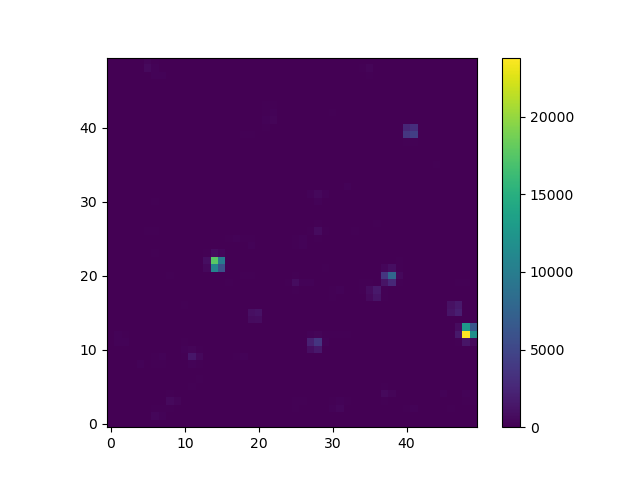

In [267]:
plt.figure()
plt.imshow(eh,origin='')
plt.colorbar()

<IPython.core.display.Javascript object>


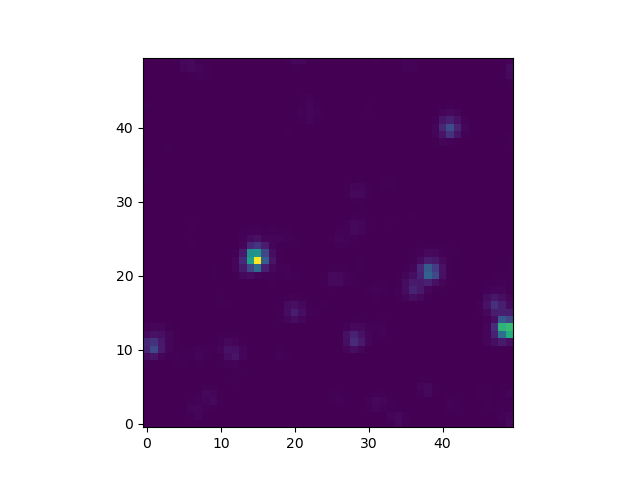

In [220]:
plt.figure()
plt.imshow(median,origin='')

In [265]:
Model_scene(20,20,0,20.44,tab,tpf,scale=100)

array([[ 6.10950318e-02,  1.17380704e+00,  4.98191740e-04, ...,
         3.18788729e-03,  2.95537616e-02,  3.51288336e-06],
       [ 3.80494948e+00,  7.31037593e+01,  3.24480955e-02, ...,
         1.12897747e+01,  4.94107907e+01,  5.85185531e-03],
       [ 8.46051343e-03,  1.62550210e-01,  1.30791763e-01, ...,
         4.08396732e+00,  6.25824845e+00,  5.79101916e-04],
       ...,
       [-7.13712899e-13, -2.49678139e-13,  2.28752976e-03, ...,
         1.15056935e+01,  1.43370802e+01,  8.45071047e-06],
       [-1.41961019e-14,  2.46149259e-13,  1.47762563e-05, ...,
         1.71937682e-01,  1.20851786e-02,  7.12355868e-09],
       [-1.85891639e-14,  7.12045180e-14,  9.91388453e-08, ...,
         4.32296890e-13, -1.68326641e-13, -3.05626941e-14]])

In [264]:
def Model_scene(sigx,sigy,thet,zp,table,tpf,scale=10):
    template = Make_scene(table,zp,tpf,scale)
    kernal = Gaussian_kernal(sigx,sigy,thet)
    template = signal.fftconvolve(template, kernal, mode='same')
    template = sd.Downsample(template,scale,pix_response=False)
    return template

def minimize_scene(k0,table,reference,tpf,scale=100):
    print(k0)
    template = Model_scene(k0[0],k0[1],k0[2],k0[3],table,tpf)
    r = reference
    t = template / r
    r = r/r
    t[~np.isfinite(t)] = np.nan
    r[~np.isfinite(r)] = np.nan
    res = np.nansum(abs(t-r))
    print(res)
    return res
    

In [239]:
k0 = [10,10,0,20.44]
res = minimize(minimize_scene, k0, args=(tab,median,tpf))
res

[10.   10.    0.   20.44]
112187655.47152713
[10.00000001 10.          0.         20.44      ]
112187655.47737063
[10.         10.00000001  0.         20.44      ]
112187655.46785888
[1.00000000e+01 1.00000000e+01 1.49011612e-08 2.04400000e+01]
112187655.47152713
[10.         10.          0.         20.44000001]
112187657.01124823
[ 9.99616692 10.00240621  0.         19.43001014]
44253733.05589304
[ 9.99616693 10.00240621  0.         19.43001014]
44253733.05820867
[ 9.99616692 10.00240623  0.         19.43001014]
44253733.05444965
[9.99616692e+00 1.00024062e+01 1.49011612e-08 1.94300101e+01]
44253733.05589583
[ 9.99616692 10.00240621  0.         19.43001015]
44253733.66321818
[-1178.28603253  -378.3898598   -308.80427074    22.34050652]
13633797.820113694
[-1178.28603251  -378.3898598   -308.80427074    22.34050652]
13633797.820285352
[-1178.28603253  -378.38985979  -308.80427074    22.34050652]
13633797.82063193
[-1178.28603253  -378.3898598   -308.80427073    22.34050652]
13633797.81

KeyboardInterrupt: 

In [248]:
def log_prior(theta):
    x, y, t,zp = theta
    if 0 < x < 100 and 0 < y < 100 and -np.pi < t < np.pi and 15< zp < 22:
        return 0.0
    return -np.inf

def log_likelihood(theta,reference,table,tpf):
    x, y, t,zp = theta
    model = Model_scene(x,t,t,zp,table,tpf)
    sigma2 = tpf.flux_err** 2 + model ** 2
    return -0.5 * np.sum((reference - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta,reference,table,tpf):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, reference,table,tpf)

In [249]:
import emcee
guess = np.array([10,10,0,20.44])
pos = guess + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(median,tab,tpf))
sampler.run_mcmc(pos, 5000, progress=True);

  1%|▏         | 72/5000 [56:11<61:02:32, 44.59s/it]Traceback (most recent call last):
  File "/Users/rridden/miniconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-248-c52fd1310456>", line 17, in log_probability
    return lp + log_likelihood(theta, reference,table,tpf)
  File "<ipython-input-248-c52fd1310456>", line 9, in log_likelihood
    model = Model_scene(x,t,t,zp,table,tpf)
KeyboardInterrupt
  1%|▏         | 72/5000 [56:50<64:49:56, 47.36s/it]

emcee: Exception while calling your likelihood function:
  params: [ 6.19619841  5.39501863  1.99524901 21.8144349 ]
  args: (array([[ 3.42536189e+01,  3.41632471e+01,  6.47594588e+00, ...,
         1.75605871e+01,  1.11732718e+02,  3.22752162e+02],
       [ 2.90561783e+01,  3.84140366e+01,  6.97115525e+00, ...,
         3.06560366e+01,  1.37619718e+02,  2.17460466e+02],
       [ 3.23464527e+01,  2.66010284e+01,  8.41458964e-02, ...,
         8.47006902e+01,  6.25693547e+01,  6.60287645e+01],
       ...,
       [-5.22367798e-03,  9.77271021e-03,  8.31194833e-03, ...,
         4.28608685e+00,  7.36468765e+01,  3.71857837e+02],
       [ 1.30819969e-03,  1.16437921e-03, -9.90832551e-03, ...,
         8.17183044e-01,  8.18724844e+01,  4.62011923e+02],
       [ 1.92778241e-05,  1.75325078e-03, -7.15478630e-03, ...,
         2.48518923e+00,  3.20401113e+01,  1.67547596e+02]]),                     objID     RAJ2000    DEJ2000  e_RAJ2000  e_DEJ2000  \
1268   182402996766947522  299.676649  62.

KeyboardInterrupt: 

In [ ]:
tpf.flux_err